In [4]:
#!/usr/bin/env python3
"""
Simple Correlated Noise Example for ReadSpyn

This is a minimal example showing how to implement correlated eps_noise
between multiple sensors in ReadSpyn.

Author: AI Assistant
Date: 2024
"""

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

# Import ReadSpyn components
import sys
import os
sys.path.append("../src/")

from readout_simulator.quantum_dot_system import QuantumDotSystem
from readout_simulator.sensor_backend import RLC_sensor
from readout_simulator.jax_simulator import JAXReadoutSimulator
from readout_simulator.noise_models import OverFNoise, CorrelatedNoise

Simple Correlated Noise Example
Dot-sensor coupling strength (Δε/ε_w): [[ 5.00000000e-01  1.67856658e-17]
 [-6.92950436e-18  5.00000000e-01]]
Created system with 2 dots and 2 sensors
[RLC_sensor] Initialized with:
  Lc = 8.000e-07 H
  Cp = 6.000e-13 F
  Self-capacitance = 0.000e+00 F
  Total capacitance = 6.000e-13 F
  RL = 40 Ω
  Rc = 1.000e+08 Ω
  Z0 = 50.0 Ω
  R0 = 5.000e+01 Ω
  g0 = 2.000e-02 S
  eps_w = 1.000e+00 eV
  Resonant frequency = 2.297e+08 Hz
  Resonant period = 4.353e-09 s
  Capacitance noise model: None
  Energy noise model: None
[RLC_sensor] Initialized with:
  Lc = 8.000e-07 H
  Cp = 6.000e-13 F
  Self-capacitance = 0.000e+00 F
  Total capacitance = 6.000e-13 F
  RL = 40 Ω
  Rc = 1.000e+08 Ω
  Z0 = 50.0 Ω
  R0 = 5.000e+01 Ω
  g0 = 2.000e-02 S
  eps_w = 1.000e+00 eV
  Resonant frequency = 2.297e+08 Hz
  Resonant period = 4.353e-09 s
  Capacitance noise model: None
  Energy noise model: None
Created correlated noise with correlation matrix:
[[1.  0.7]
 [0.7 1. ]]

Simul

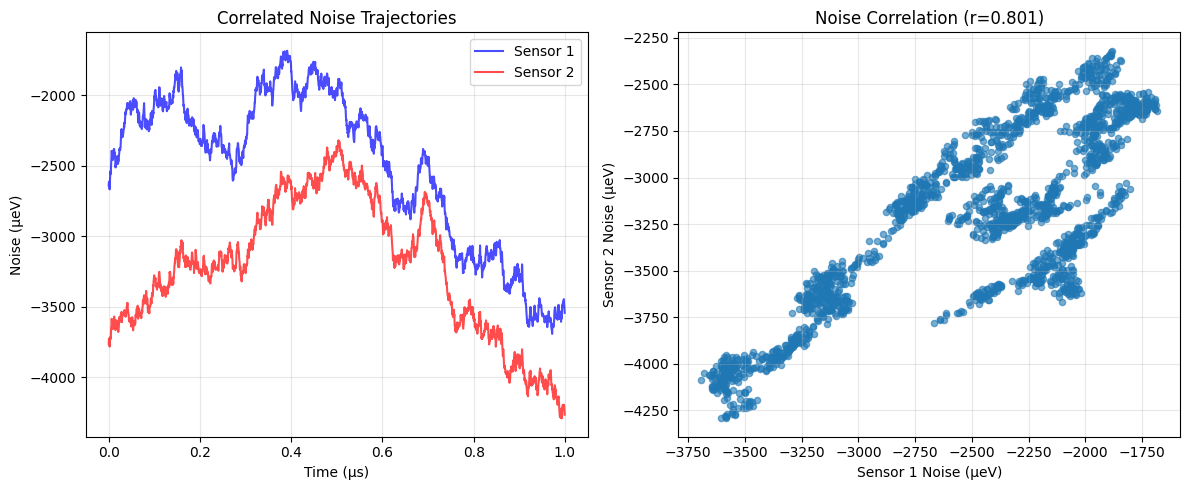


Example completed successfully!
The correlated noise implementation allows you to:
- Set correlation strength between sensors
- Use any base noise model (OU_noise, OverFNoise)
- Maintain JAX compatibility for efficient computation


In [5]:
"""Simple example of correlated noise implementation."""
print("Simple Correlated Noise Example")
print("=" * 40)

# Set random seed
key = jr.PRNGKey(123)

# 1. Create a quantum dot system with 2 dots and 2 sensors
# Dot-dot capacitance matrix (2x2)
Cdd = np.array([
    [1.0e-15, 0.2e-15],  # Dot 1 self-capacitance and coupling to dot 2
    [0.2e-15, 1.0e-15]   # Dot 2 self-capacitance and coupling to dot 1
])

# Dot-sensor capacitance matrix (2x2)
Cds = np.array([
    [0.5e-15, 0.1e-15],  # Dot 1 coupling to sensors
    [0.1e-15, 0.5e-15]   # Dot 2 coupling to sensors
])

dot_system = QuantumDotSystem(Cdd, Cds)
print(f"Created system with {dot_system.num_dots} dots and {dot_system.num_sensors} sensors")

# 2. Create two identical sensors
params_resonator = {
    'Lc': 800e-9, 'Cp': 0.6e-12, 'RL': 40, 'Rc': 100e6, 'Z0': 50.0
}
params_coulomb_peak = {
    'g0': 1/50, 'eps0': 0.5, 'eps_width': 1.0
}

sensors = []
for i in range(2):
    sensor = RLC_sensor(params_resonator, params_coulomb_peak)
    sensors.append(sensor)

# 3. Create base noise model (1/f noise)
base_noise = OverFNoise(
    n_fluctuators=3, 
    S1=1e-6, 
    sigma_couplings=0.1,
    ommax=1e6, 
    ommin=1e3
)

# 4. Create correlation matrix for the sensors
# This creates moderate positive correlation between sensors
correlation_matrix = jnp.array([
    [1.0, 0.7],  # Sensor 1 correlated with sensor 2
    [0.7, 1.0]   # Sensor 2 correlated with sensor 1
])

# 5. Create correlated noise model
correlated_noise = CorrelatedNoise(base_noise, correlation_matrix)
print(f"Created correlated noise with correlation matrix:")
print(correlation_matrix)

# 6. Create simulator
simulator = JAXReadoutSimulator(dot_system, sensors)

# 7. Define simulation parameters
charge_states = jnp.array([[1, 0], [0, 1]])  # Two charge states
t_end = 1e-6  # 1 μs
dt = 0.5e-9   # 0.5 ns
times = jnp.arange(0, t_end, dt)
n_realizations = 5

print(f"\nSimulation parameters:")
print(f"  Time: {t_end*1e6:.1f} μs, dt: {dt*1e9:.1f} ns")
print(f"  Realizations: {n_realizations}")

# 8. Precompute correlated noise trajectories
simulator.precompute_noise(key, times, n_realizations, correlated_noise)

# 9. Run simulation
params = {'snr': 1.0, 't_end': t_end}
results = simulator.run_simulation(charge_states, times, params, key)

# 10. Analyze the correlation
print("\nAnalyzing correlation effects...")

# Extract noise trajectories for first realization
sensor1_noise = results['sensor_results'][0]['noise_trajectory'][0, 0]  # First state, first realization
sensor2_noise = results['sensor_results'][1]['noise_trajectory'][0, 0]

# Calculate actual correlation coefficient
correlation_coeff = np.corrcoef(sensor1_noise, sensor2_noise)[0, 1]
print(f"Actual correlation coefficient: {correlation_coeff:.4f}")
print(f"Target correlation coefficient: {correlation_matrix[0, 1]:.4f}")

# 11. Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot noise trajectories
ax1.plot(times*1e6, sensor1_noise*1e6, 'b-', label='Sensor 1', alpha=0.7)
ax1.plot(times*1e6, sensor2_noise*1e6, 'r-', label='Sensor 2', alpha=0.7)
ax1.set_xlabel('Time (μs)')
ax1.set_ylabel('Noise (μeV)')
ax1.set_title('Correlated Noise Trajectories')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot correlation scatter
ax2.scatter(sensor1_noise*1e6, sensor2_noise*1e6, alpha=0.6, s=20)
ax2.set_xlabel('Sensor 1 Noise (μeV)')
ax2.set_ylabel('Sensor 2 Noise (μeV)')
ax2.set_title(f'Noise Correlation (r={correlation_coeff:.3f})')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nExample completed successfully!")
print("The correlated noise implementation allows you to:")
print("- Set correlation strength between sensors")
print("- Use any base noise model (OU_noise, OverFNoise)")
print("- Maintain JAX compatibility for efficient computation")
